In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
import os, sys
from pathlib import Path
BASE_DIR = Path('.').resolve().parent.parent
os.chdir(BASE_DIR)
from phm08ds.models import experiment

## Load Dataset

In [2]:
folderpath = './phm08ds/data/files/'
data_completed = pd.read_csv(folderpath + 'data_preprocessed.csv')
data_completed.head()

,unit,time_step,operational_setting_1,operational_setting_2,operational_setting_3,Sensor_0,Sensor_1,Sensor_2,Sensor_3,Sensor_4,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Health_state,Operational_condition
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735,1,1
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619,1,3
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555,1,4
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832,1,2
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025,1,4


## Data preprocessing

Use the pipeline and mlp

In [3]:
from phm08ds.data.preprocessing import OperationalCondition
data_unlabel = data_completed.drop(labels=['Health_state', 'Operational_condition'], axis=1)
tf_op_cond = OperationalCondition()
op_cond = tf_op_cond.fit_transform(data_unlabel.loc[0])

from phm08ds.features.feature_selection import RemoveSensor
tf_select_sensor = RemoveSensor(sensors=[4,5,7,9,15,16,17,18])
data_important_sensors = tf_select_sensor.fit_transform(data_unlabel).iloc[:,5:]

from sklearn.preprocessing import StandardScaler
tf_std = StandardScaler()
data_elman = tf_std.fit_transform(data_important_sensors)

In [4]:
data_important_sensors.head()

,Sensor_0,Sensor_1,Sensor_2,Sensor_3,Sensor_6,Sensor_8,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_19,Sensor_20
0,489.05,604.13,1499.45,1309.95,394.88,8770.20,45.40,372.15,2388.13,8120.83,8.6216,28.58,17.1735
1,518.67,642.13,1584.55,1403.96,553.67,9045.76,47.29,521.81,2388.15,8132.87,8.3907,38.99,23.3619
2,449.44,555.42,1368.17,1122.49,194.93,8343.91,41.92,183.26,2387.95,8063.84,9.3557,14.83,8.8555
3,491.19,607.03,1488.44,1249.18,334.82,8721.53,44.26,314.84,2388.07,8052.30,9.2231,24.42,14.7832
4,445.00,549.52,1354.48,1124.32,138.24,8314.56,41.79,130.44,2387.89,8083.67,9.2986,10.99,6.4025


In [5]:
data_elman

array([[ 0.61180613,  0.65613257,  0.7480038 , ..., -0.94547527,
         0.78791419,  0.79220892],
       [ 1.73123631,  1.67242914,  1.54867518, ..., -1.25259429,
         1.83904831,  1.83369583],
       [-0.88517663, -0.64659916, -0.48715647, ...,  0.03094771,
        -0.60047142, -0.60768251],
       ...,
       [-1.05297778, -0.79369471, -0.57145747, ...,  0.19986982,
        -1.05081322, -1.05496448],
       [-0.88517663, -0.61637771, -0.37538237, ...,  0.11806896,
        -0.61359797, -0.63787493],
       [-0.39008766, -1.12693301, -1.36704821, ...,  2.18450507,
        -0.66509446, -0.6654924 ]])

In [6]:
labels = np.array(data_completed['Health_state'])

In [7]:
from sklearn.preprocessing import LabelBinarizer

tf_label_binarize = LabelBinarizer(neg_label=-1)
labels_encoded = tf_label_binarize.fit_transform(labels)

In [8]:
data_important_sensors.to_csv('./notebooks/E10_PHM08-train_Elman/data_op_01_cleaned.csv')

In [9]:
data_completed['Health_state'].to_csv('./notebooks/E10_PHM08-train_Elman/data_op_01_cleaned_labels.csv')

# Classification steps

## How to use Elman network of neurolab

Folllowing the example at https://pythonhosted.org/neurolab/ex_newelm.html

In [10]:
import neurolab as nl

In [11]:
min_list = []
max_list = []

for feature in range(0,data_elman.shape[1]):
    min_list.append(data_elman[:,feature].min())
    max_list.append(data_elman[:,feature].max())
    
min_max_list = list(map(list, list(zip(min_list, max_list))))
min_max_list

[[-1.0529777759307313, 1.7312363125165662],
 [-1.1753408204944527, 1.7339418274655676],
 [-1.6419673391525405, 1.8319679582054447],
 [-1.4736907733144127, 1.979853866522363],
 [-0.994418605370454, 1.8647090189004631],
 [-1.5880108143073062, 2.058586142420622],
 [-2.09095267529294, 1.6643198057833244],
 [-0.9894413393070688, 1.863872647846903],
 [-2.3863356006116327, 0.4403704606088263],
 [-2.5182537467342794, 2.4637870778705158],
 [-1.3395825202119227, 2.327889347726539],
 [-1.0649495104567193, 1.8733792980137947],
 [-1.0669472031910918, 1.872168443711449]]

In [12]:
elman_clf = nl.net.newelm(min_max_list, [50,4], [nl.trans.TanSig(), nl.trans.PureLin()])

In [13]:
# Set initialized functions and init
elman_clf.layers[0].initf = nl.init.InitRand([-0.01, 0.01], 'w')
elman_clf.layers[1].initf= nl.init.InitRand([-0.01, 0.01], 'w')

# elman_clf.layers[0].initf = nl.init.initnw(1)
# elman_clf.layers[1].initf= nl.init.initnw([-0.1, 0.1], 'wb')
elman_clf.init()

In [14]:
# Train network
error = elman_clf.train(data_elman, labels_encoded, epochs=10, goal=0.1, adapt=True, show=1)
# Simulate network
output = elman_clf.sim(data_elman)

Epoch: 1; Error: 1.1399822702237228;
Epoch: 2; Error: 0.9933037950000556;


/Users/tomxu/miniforge3/envs/ml/lib/python3.9/site-packages/neurolab/tool.py:187: RuntimeWarning: overflow encountered in multiply
  dS = np.sum(net.layers[next].np['w'] * delt[next], axis=0)
/Users/tomxu/miniforge3/envs/ml/lib/python3.9/site-packages/neurolab/tool.py:188: RuntimeWarning: invalid value encountered in multiply
  delt[ln] = dS * layer.transf.deriv(layer.s, layer.out)


Epoch: 3; Error: nan;
Epoch: 4; Error: nan;
Epoch: 5; Error: nan;
Epoch: 6; Error: nan;
Epoch: 7; Error: nan;
Epoch: 8; Error: nan;
Epoch: 9; Error: nan;
Epoch: 10; Error: nan;
The maximum number of train epochs is reached


In [15]:
error

[1.1399822702237228,
 0.9933037950000556,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

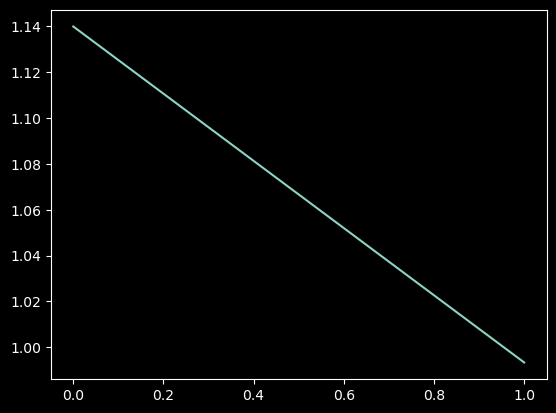

In [16]:
plt.plot(error)

### Test the newtwork

In [17]:
real_targets = labels.reshape(-1)
real_targets

array([1, 1, 1, ..., 4, 4, 4])

In [18]:
predicted_targets = tf_label_binarize.inverse_transform(output)

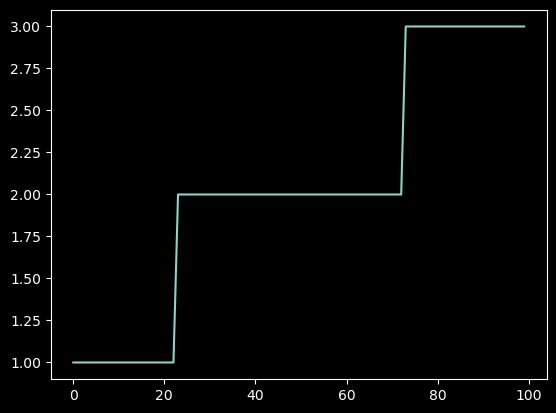

In [19]:
until_to = 100

plt.figure()
plt.plot(real_targets[:until_to])
plt.plot(output[:until_to])

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [21]:
accuracy_score(real_targets, predicted_targets)

0.1100875473670456

In [22]:
confusion_matrix(real_targets, predicted_targets)

array([[ 5055,     0,     0,     0],
       [ 8278,     0,     0,     0],
       [21467,     0,     0,     0],
       [11118,     0,     0,     0]])